### Testing Evo

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch_geometric
from torch_geometric.nn import GCNConv
import IPython
from IPython.display import display, HTML, Image

from graphUtils import add_edges
from generator import generate_organism
from cell import Cell
from organism import Organism
from GNCAmodel import GNCA
from visualizer import Visualizer
from evo_trainer import Evo_Trainer

#%run Visualizer.py # --allows for reloading the particular code

#### Train the network

In [2]:
n = 10
popsize = 30
generations = 500
name = 'centered5'
#device = torch.device('mps:0')
device = torch.device('cpu')
trainer = Evo_Trainer(n, device)
trainer = Evo_Trainer(n, device, popsize)

2023-02-19 21:50:38,202	INFO worker.py:1528 -- Started a local Ray instance.


[2023-02-19 21:50:40] INFO     <12290> evotorch.core: Instance of `Custom_NEProblem` (id:4435520064) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-02-19 21:50:40] INFO     <12290> evotorch.core: Instance of `Custom_NEProblem` (id:4435520064) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-02-19 21:50:40] INFO     <12290> evotorch.core: Instance of `Custom_NEProblem` (id:4435520064) -- The `device` of the problem is set as cpu
[2023-02-19 21:50:40] INFO     <12290> evotorch.core: Instance of `Custom_NEProblem` (id:4435520064) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-02-19 21:50:40] INFO     <12290> evotorch.core: Instance of `Custom_NEProblem` (id:4435520064) -- Number of GPUs that will be allocated per actor is None


/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/tools/misc.py:1107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(data, **kwargs)


[2023-02-19 21:50:42] INFO     <12290> evotorch.core: Instance of `Custom_NEProblem` (id:11001978480) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-02-19 21:50:42] INFO     <12290> evotorch.core: Instance of `Custom_NEProblem` (id:11001978480) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-02-19 21:50:42] INFO     <12290> evotorch.core: Instance of `Custom_NEProblem` (id:11001978480) -- The `device` of the problem is set as cpu
[2023-02-19 21:50:42] INFO     <12290> evotorch.core: Instance of `Custom_NEProblem` (id:11001978480) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-02-19 21:50:42] INFO     <12290> evotorch.core: Instance of `Custom_NEProblem` (id:11001978480) -- Number of GPUs that will be allocated per actor is None


In [3]:
trainer.train(generations, name)

         iter : 1
     stepsize : ReadOnlyTensor(0.9928)
    mean_eval : 101.29524993896484
pop_best_eval : 848.211669921875
  median_eval : -14.710445404052734

         iter : 2
     stepsize : ReadOnlyTensor(0.9861)
    mean_eval : 80.64757537841797
pop_best_eval : 750.2203369140625
  median_eval : 0.8779478073120117

         iter : 3
     stepsize : ReadOnlyTensor(0.9797)
    mean_eval : 20.38370704650879
pop_best_eval : 700.7560424804688
  median_eval : -30.13161277770996

         iter : 4
     stepsize : ReadOnlyTensor(0.9736)
    mean_eval : 91.60236358642578
pop_best_eval : 2149.956298828125
  median_eval : -64.37010192871094

         iter : 5
     stepsize : ReadOnlyTensor(0.9677)
    mean_eval : 59.08631134033203
pop_best_eval : 911.0872802734375
  median_eval : -26.40854835510254

         iter : 6
     stepsize : ReadOnlyTensor(0.9621)
    mean_eval : 219.2254180908203
pop_best_eval : 3528.65576171875
  median_eval : 37.19061279296875

         iter : 7
     stepsize : R

In [ ]:
network = trainer.get_trained_network()

In [ ]:
#network = trainer.problem.parameterize_net(trainer.searcher.status['best'][0])
network = trainer.problem.parameterize_net(trainer.searcher.status['center'][0])

#### Visualize trained network

In [ ]:
organism = generate_organism(n, device)
graph = organism.toGraph()
visualizer = Visualizer()
network(graph, 0)

(Data(x=[30, 10], edge_index=[1, 0], device=cpu, attr=[1]),
 tensor([0., 0.]),
 0.0,
 0.0,
 0.0,
 0.0,
 0.0)

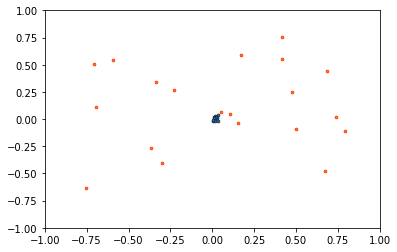

In [ ]:
anim = visualizer.animate_organism(graph, network, food=30, frames=60)
visualizer.save_animation_to_gif(anim, name, 10)

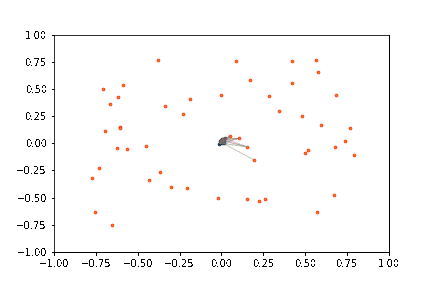

In [ ]:
Image('../animation/' + name + '.gif')

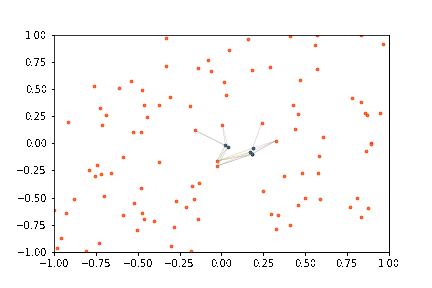

In [ ]:
Image('../animation/GATConv1.gif')

In [ ]:
anim.frame_seq = anim.new_saved_frame_seq() 
IPython.display.HTML(anim.to_jshtml())

In [ ]:
print(network)

CGConv1(
  (conv_layer_cells): CGConv(10, dim=4)
  (conv_layer_food): CGConv(10, dim=4)
  (mlp): Sequential(
    (0): ReLU()
    (1): Linear(in_features=20, out_features=7, bias=True)
    (2): Tanh()
  )
  (mlp_before): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
)


In [ ]:
print('conv_layers1: ', network.conv_layer_cells)
for param in network.conv_layer_cells.parameters():
  print(param.data)

print('conv_layers2: ', network.conv_layer_food)
for param in network.conv_layer_food.parameters():
  print(param.data)

conv_layers1:  CGConv(10, dim=4)
tensor([[ 2.6063e+00,  1.1805e+00, -8.2205e-02,  7.2681e+00,  7.1501e+00,
         -2.6979e+00,  3.8895e-01,  3.6973e+00,  6.4213e+00, -1.2837e+01,
          4.4545e+00, -6.2252e+00,  8.9659e-01, -1.5591e+01,  9.3124e+00,
          6.3212e+00, -6.3160e+00,  9.6146e-01, -1.3181e+01, -6.4549e-01,
          5.8780e+00, -2.3775e+00,  2.7514e+00,  6.1060e+00],
        [ 2.0964e+00,  3.6263e+00, -5.6324e-01, -3.1418e+00,  5.5013e-01,
          6.5502e+00, -6.4599e+00, -1.5271e+00, -6.0896e+00, -4.2714e+00,
         -3.7704e+00, -7.7493e+00,  9.0288e+00, -7.6301e-01, -2.5107e+00,
          6.3633e-01, -6.1227e+00, -9.7597e-01,  5.9022e+00, -1.0412e+01,
          9.8323e+00,  6.3306e+00, -1.2588e+00,  8.8838e+00],
        [ 3.4020e+00, -2.0367e+00,  3.5556e+00,  2.6361e+00, -4.0293e-01,
         -5.1337e+00,  3.2241e+00, -7.2566e+00, -2.1911e+00,  5.9752e-01,
         -7.4488e-01, -1.2801e+00, -4.9443e+00,  4.9366e+00, -7.6772e+00,
          8.9010e+00,  3.3252

In [ ]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>